In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
from statsmodels import datasets
from theano import tensor as T
import pandas as pd

In [2]:

#Load mastectomy dataset
df = datasets.get_rdataset('mastectomy', 'HSAUR', cache=True).data
#Change event to integer
df.event = df.event.astype(np.int64)
#Change metastized to integer (1 for yes, 0 for no)
df.metastized = (df.metastized == 'yes').astype(np.int64)
#Count the number of patients
n_patients = df.shape[0]
#Create array for each individual patient
patients = np.arange(n_patients)

#Censoring - we do not observe the death of every subject, and subjects may still be alive at time t=0
#1 - observation is not censored (death was observed)
#0 - observation is censored (death was not observed)
nonCensored = df.event.mean()

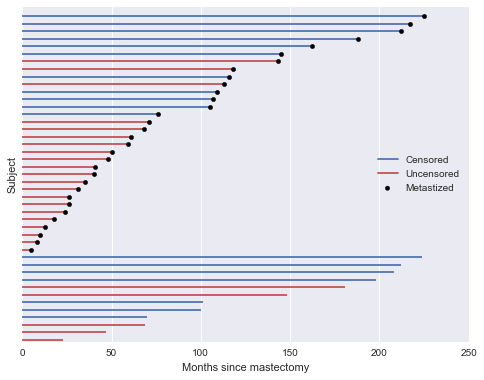

In [3]:
#Create censoring plot
fig, ax = plt.subplots(figsize=(8, 6))
blue, _, red = sns.color_palette()[:3]
#Create horizontal lines for censored observations
ax.hlines(patients[df.event.values == 0], 0, df[df.event.values == 0].time,
          color=blue, label='Censored')
#Create horizontal red lines for uncensored observations
ax.hlines(patients[df.event.values == 1], 0, df[df.event.values == 1].time,
          color=red, label='Uncensored')
#Create scatter ppoints for metastized months
ax.scatter(df[df.metastized.values == 1].time, patients[df.metastized.values == 1],
           color='k', zorder=10, label='Metastized')
ax.set_xlim(left=0)
ax.set_xlabel('Months since mastectomy')
ax.set_yticks([])
ax.set_ylabel('Subject')
ax.set_ylim(-0.25, n_patients + 0.25)
ax.legend(loc='center right')

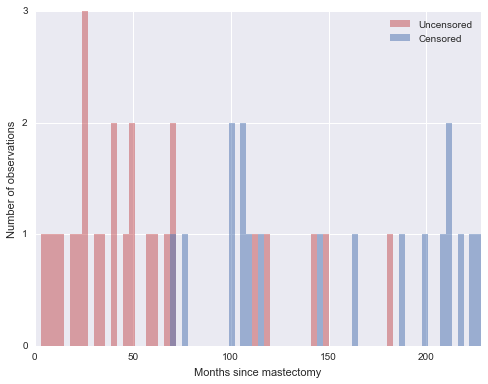

In [4]:
#To understand the impact of metastization on survival time, we use a risk regression model
#Cox proportional hazards model
#Make intervals 3 months long
interval_length = 3
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
#Check how deaths and censored observations are distributed in intervals
fig, ax = plt.subplots(figsize=(8, 6))
#Plot histogram of uncensored events
ax.hist(df[df.event == 1].time.values, bins=interval_bounds,
        color=red, alpha=0.5, lw=0,
        label='Uncensored')
#Plot histogram of censored events
ax.hist(df[df.event == 0].time.values, bins=interval_bounds,
        color=blue, alpha=0.5, lw=0,
        label='Censored')
ax.set_xlim(0, interval_bounds[-1])
ax.set_xlabel('Months since mastectomy')
ax.set_yticks([0, 1, 2, 3])
ax.set_ylabel('Number of observations')
ax.legend()

In [6]:
#Calculates the last interval period when a subject was alive
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)
#Creates an empty matrix to store deaths
death = np.zeros((n_patients, n_intervals))
#For each patient (row), create an event where the last interval period was observed (column)
death[patients, last_period] = df.event

#Create matrix of the amount of time a subject (row) was at risk in an interval (column)
exposure = np.greater_equal.outer(df.time, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

#Define parameters for PyMC
SEED = 5078864
n_samples = 1000
n_tune = 1000

#Create PyMC model -> lambda(t) = lambda0(t) * e ^ (X*beta)
with pm.Model() as model:
    #Define prior distribution of hazards as vague Gamma distribution
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    #Define hazard regression coefficients (beta) for covariates X as a normal distribution
    beta = pm.Normal('beta', 0, sd=1000)

    #Create equation for lambda(t) as a deterministic node - record sampled values as part of output
    #T.outer = symbolic matrix, vector-vector outer product
    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.metastized), lambda0))
    #Mu is created from our lambda values (hazard) times patient exposure per interval
    mu = pm.Deterministic('mu', exposure * lambda_)

    #We model the posterior distribution as a Poisson distribution with mean Mu
    obs = pm.Poisson('obs', mu, observed=death)

with model:
    trace = pm.sample(n_samples, tune=n_tune, random_seed=SEED)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:22<00:00,  6.23it/s]C:\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:463: UserWarning: Chain 0 contains 96 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



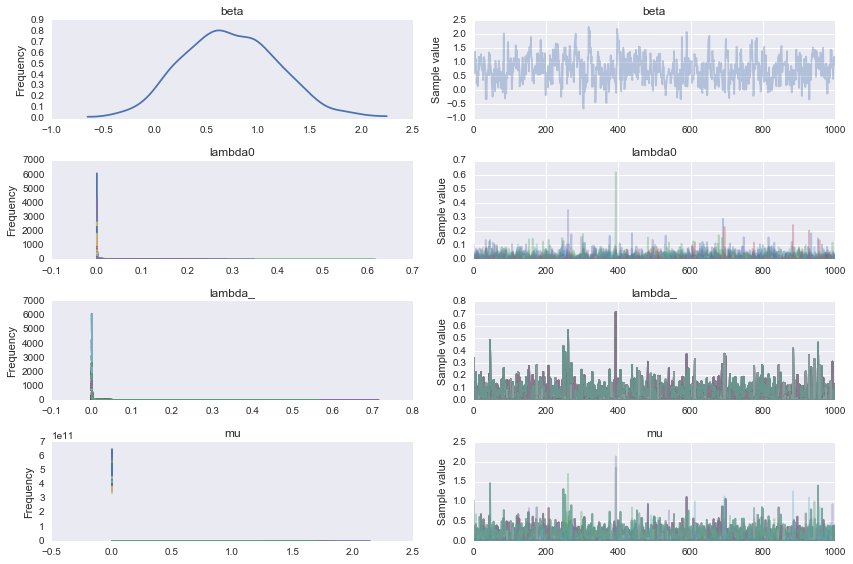

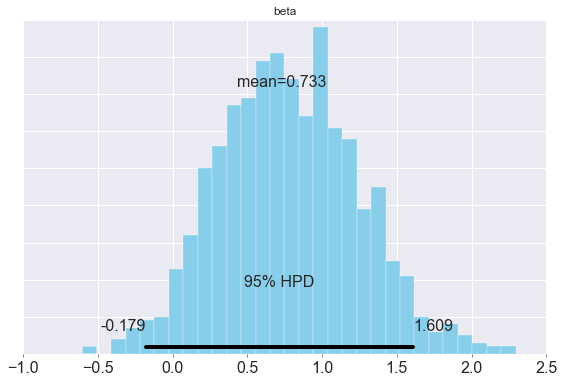

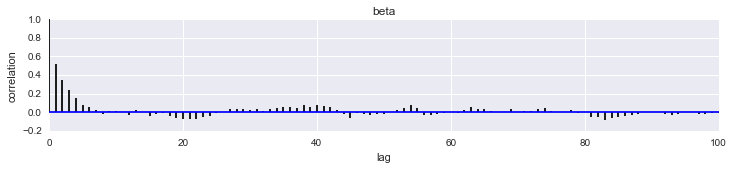

In [7]:
pm.traceplot(trace)

#Calculate hazard rate for subjects with metastized cancer (based on regression coefficients)
hazardRate = np.exp(trace['beta'].mean())
pm.plot_posterior(trace, varnames=['beta'], color='#87ceeb')
pm.autocorrplot(trace, varnames=['beta'])

In [8]:
#Store base hazard as well as metastized hazard for each sample per interval
#(sample x number of intervals)
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

#Calculate cumulative hazard
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

#Calculative survival as = e^(-cumulative hazard)
def survival(hazard):
    return np.exp(-cum_hazard(hazard))

#Plot highest posterior density
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    #Use function f on hazard mean
    mean = f(hazard.mean(axis=0))
    #Create confidence percentiles
    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label)

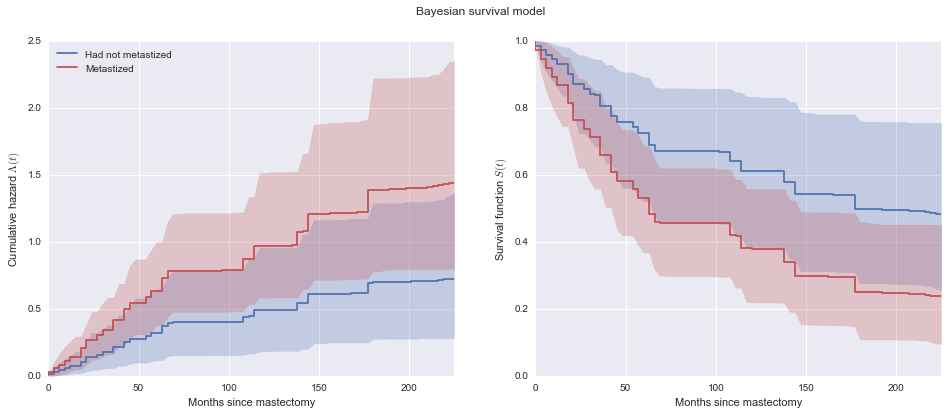

In [9]:
#Create figure
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))
#Plot Hazard with HPD up until the last interval for non-metasized cancer
plot_with_hpd(interval_bounds[:-1], base_hazard, cum_hazard,
              hazard_ax, color=blue, label='Had not metastized')
#Plot Hazard with HPD up until the last interval for metasized cancer
plot_with_hpd(interval_bounds[:-1], met_hazard, cum_hazard,
              hazard_ax, color=red, label='Metastized')
hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel('Months since mastectomy')
hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$')
hazard_ax.legend(loc=2)
#Plot Survival with HPD up until the last interval for non-metasized cancer
plot_with_hpd(interval_bounds[:-1], base_hazard, survival,
              surv_ax, color=blue)
#Plot Survival with HPD up until the last interval for metasized cancer
plot_with_hpd(interval_bounds[:-1], met_hazard, survival,
              surv_ax, color=red)
surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel('Months since mastectomy')
surv_ax.set_ylabel('Survival function $S(t)$')
fig.suptitle('Bayesian survival model')

In [10]:
#Consider time varying effects
with pm.Model() as time_varying_model:
    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)
    #Beta is now modeled as a normal random walk instead of a normal distribution
    #This is due to the fact that the regression coefficients can vary over time
    beta = GaussianRandomWalk('beta', tau=1., shape=n_intervals)

    lambda_ = pm.Deterministic('h', lambda0 * T.exp(T.outer(T.constant(df.metastized), beta)))
    mu = pm.Deterministic('mu', exposure * lambda_)

    obs = pm.Poisson('obs', mu, observed=death)

with time_varying_model:
    time_varying_trace = pm.sample(n_samples, tune=n_tune, random_seed=SEED)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:54<00:00,  2.84it/s]C:\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:455: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
C:\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:463: UserWarning: Chain 0 contains 183 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



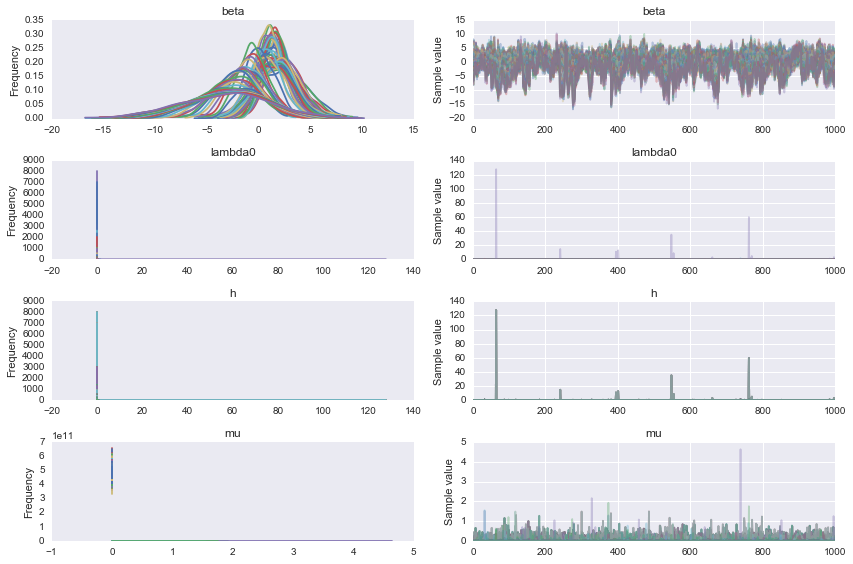

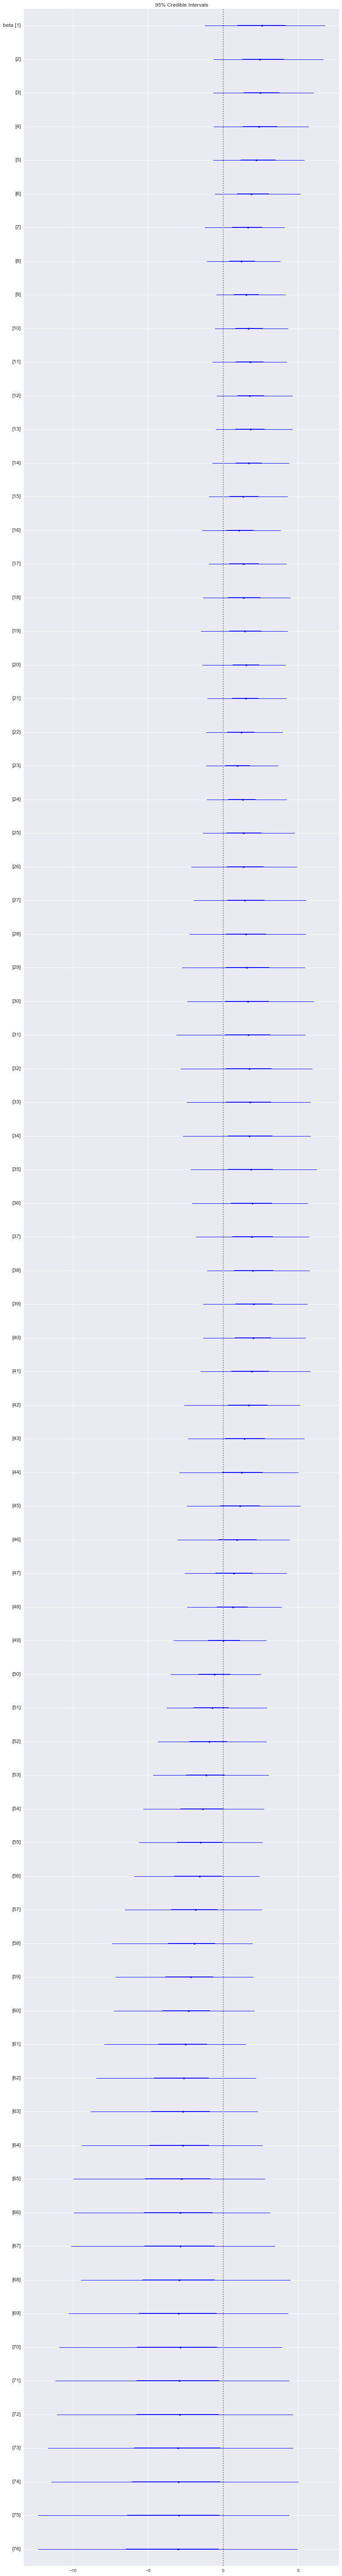

In [11]:

pm.traceplot(time_varying_trace)
pm.plot_posterior(time_varying_trace, varnames=['beta'], color='#87ceeb')
pm.forestplot(time_varying_trace, varnames=['beta'])

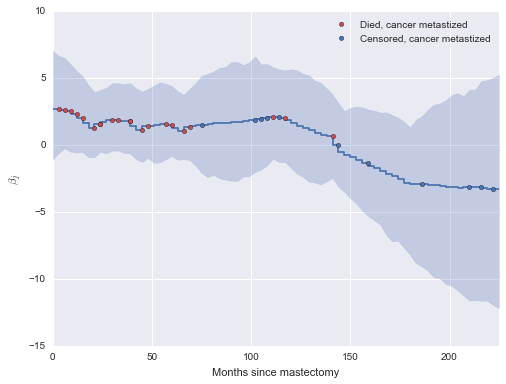

In [12]:
#Create plot to show the mean trace of beta
fig, ax = plt.subplots(figsize=(8, 6))
#Create percentiles of the new trace
beta_hpd = np.percentile(time_varying_trace['beta'], [2.5, 97.5], axis=0)
beta_low = beta_hpd[0]
beta_high = beta_hpd[1]
#Fill percentile interval
ax.fill_between(interval_bounds[:-1], beta_low, beta_high,
                color=blue, alpha=0.25)
#Create the mean estimate for beta from trace samples
beta_hat = time_varying_trace['beta'].mean(axis=0)
#Plot a stepwise line for beta_hat per interval
ax.step(interval_bounds[:-1], beta_hat, color=blue)
#Plot points where cancer was metastized, differentiation between death and censorship
ax.scatter(interval_bounds[last_period[(df.event.values == 1) & (df.metastized == 1)]],
           beta_hat[last_period[(df.event.values == 1) & (df.metastized == 1)]],
           c=red, zorder=10, label='Died, cancer metastized')
ax.scatter(interval_bounds[last_period[(df.event.values == 0) & (df.metastized == 1)]],
           beta_hat[last_period[(df.event.values == 0) & (df.metastized == 1)]],
           c=blue, zorder=10, label='Censored, cancer metastized')
ax.set_xlim(0, df.time.max())
ax.set_xlabel('Months since mastectomy')
ax.set_ylabel(r'$\beta_j$')
ax.legend()

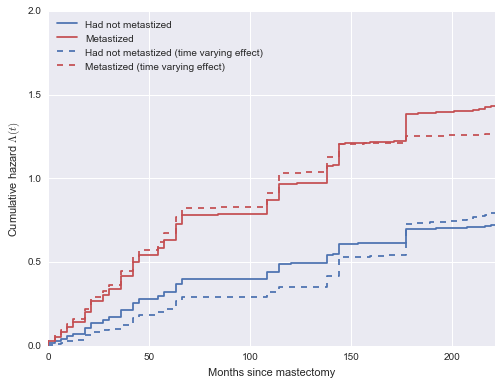

In [13]:
#Store time-varying model
tv_base_hazard = time_varying_trace['lambda0']
tv_met_hazard = time_varying_trace['lambda0'] * np.exp(np.atleast_2d(time_varying_trace['beta']))

#Plot cumulative hazard functions with and without time-varying effect
fig, ax = plt.subplots(figsize=(8, 6))
ax.step(interval_bounds[:-1], cum_hazard(base_hazard.mean(axis=0)),
        color=blue, label='Had not metastized')
ax.step(interval_bounds[:-1], cum_hazard(met_hazard.mean(axis=0)),
        color=red, label='Metastized')
ax.step(interval_bounds[:-1], cum_hazard(tv_base_hazard.mean(axis=0)),
        color=blue, linestyle='--', label='Had not metastized (time varying effect)')
ax.step(interval_bounds[:-1], cum_hazard(tv_met_hazard.mean(axis=0)),
        color=red, linestyle='--', label='Metastized (time varying effect)')
ax.set_xlim(0, df.time.max() - 4)
ax.set_xlabel('Months since mastectomy')
ax.set_ylim(0, 2)
ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$')
ax.legend(loc=2)

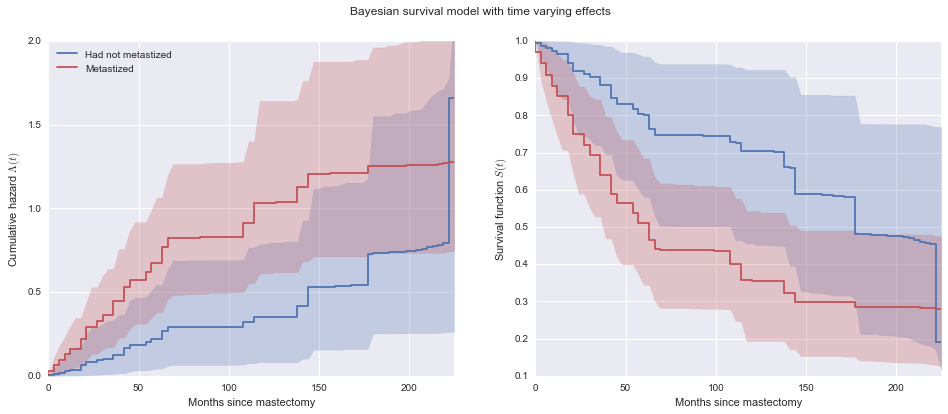

In [14]:
#Plot cumulative hazard and survival models with HPD
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))
plot_with_hpd(interval_bounds[:-1], tv_base_hazard, cum_hazard,
              hazard_ax, color=blue, label='Had not metastized')
plot_with_hpd(interval_bounds[:-1], tv_met_hazard, cum_hazard,
              hazard_ax, color=red, label='Metastized')
hazard_ax.set_xlim(0, df.time.max())
hazard_ax.set_xlabel('Months since mastectomy')
hazard_ax.set_ylim(0, 2)
hazard_ax.set_ylabel(r'Cumulative hazard $\Lambda(t)$')
hazard_ax.legend(loc=2)
plot_with_hpd(interval_bounds[:-1], tv_base_hazard, survival,
              surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], tv_met_hazard, survival,
              surv_ax, color=red)
surv_ax.set_xlim(0, df.time.max())
surv_ax.set_xlabel('Months since mastectomy')
surv_ax.set_ylabel('Survival function $S(t)$')
fig.suptitle('Bayesian survival model with time varying effects')